# Task 1: Introduction

---

We will be evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [3]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data


In [4]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

It makes easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [5]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

We will remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [7]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [8]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [9]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

In [11]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 2s 5ms/step - loss: 1.2393 - val_loss: 1.0058
Epoch 2/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2266 - val_loss: 1.0029
Epoch 3/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.2056 - val_loss: 1.0000
Epoch 4/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.1733 - val_loss: 0.9970
Epoch 5/1000
149/149 [==============================] - 0s 2ms/step - loss: 1.2052 - val_loss: 0.9940
Epoch 6/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.1759 - val_loss: 0.9910
Epoch 7/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.2004 - val_loss: 0.9881
Epoch 8/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.2065 - val_loss: 0.9851
Epoch 9/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.1491 - val_loss: 0.9821
Epoch 10/1000
149/149 [==============================] - 0s 3ms/step - loss: 1.168

149/149 [==============================] - 0s 3ms/step - loss: 0.9401 - val_loss: 0.8103
Epoch 81/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9242 - val_loss: 0.8084
Epoch 82/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9307 - val_loss: 0.8065
Epoch 83/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9662 - val_loss: 0.8045
Epoch 84/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9402 - val_loss: 0.8026
Epoch 85/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9055 - val_loss: 0.8007
Epoch 86/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9274 - val_loss: 0.7988
Epoch 87/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9550 - val_loss: 0.7969
Epoch 88/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.9249 - val_loss: 0.7949
Epoch 89/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.8908 - v

149/149 [==============================] - 0s 3ms/step - loss: 0.7640 - val_loss: 0.6799
Epoch 160/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7579 - val_loss: 0.6784
Epoch 161/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7709 - val_loss: 0.6770
Epoch 162/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7758 - val_loss: 0.6756
Epoch 163/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7396 - val_loss: 0.6741
Epoch 164/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7368 - val_loss: 0.6727
Epoch 165/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7416 - val_loss: 0.6714
Epoch 166/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7214 - val_loss: 0.6700
Epoch 167/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.7222 - val_loss: 0.6686
Epoch 168/1000
149/149 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6325 - val_loss: 0.5771
Epoch 239/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6335 - val_loss: 0.5760
Epoch 240/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6200 - val_loss: 0.5748
Epoch 241/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6120 - val_loss: 0.5736
Epoch 242/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6088 - val_loss: 0.5725
Epoch 243/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6163 - val_loss: 0.5713
Epoch 244/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6117 - val_loss: 0.5702
Epoch 245/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5911 - val_loss: 0.5691
Epoch 246/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.6210 - val_loss: 0.5679
Epoch 247/1000
149/149 [==============================] - 0s 3ms

Epoch 317/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5022 - val_loss: 0.4936
Epoch 318/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5220 - val_loss: 0.4927
Epoch 319/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5128 - val_loss: 0.4918
Epoch 320/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5012 - val_loss: 0.4908
Epoch 321/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5065 - val_loss: 0.4899
Epoch 322/1000
149/149 [==============================] - 1s 3ms/step - loss: 0.5053 - val_loss: 0.4890
Epoch 323/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4959 - val_loss: 0.4880
Epoch 324/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.5065 - val_loss: 0.4870
Epoch 325/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4860 - val_loss: 0.4861
Epoch 326/1000
149/149 [==============================] - 0s 3ms

Epoch 396/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4216 - val_loss: 0.4279
Epoch 397/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4279 - val_loss: 0.4272
Epoch 398/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4077 - val_loss: 0.4265
Epoch 399/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4153 - val_loss: 0.4258
Epoch 400/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4162 - val_loss: 0.4251
Epoch 401/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4113 - val_loss: 0.4244
Epoch 402/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4142 - val_loss: 0.4237
Epoch 403/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4151 - val_loss: 0.4231
Epoch 404/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.4275 - val_loss: 0.4224
Epoch 405/1000
149/149 [==============================] - 0s 3ms

Epoch 475/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3582 - val_loss: 0.3800
Epoch 476/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3548 - val_loss: 0.3795
Epoch 477/1000
149/149 [==============================] - 1s 4ms/step - loss: 0.3482 - val_loss: 0.3790
Epoch 478/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3529 - val_loss: 0.3785
Epoch 479/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3489 - val_loss: 0.3781
Epoch 480/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3512 - val_loss: 0.3776
Epoch 481/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3645 - val_loss: 0.3772
Epoch 482/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3513 - val_loss: 0.3768
Epoch 483/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3599 - val_loss: 0.3763
Epoch 484/1000
149/149 [==============================] - 0s 2ms

Epoch 554/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3214 - val_loss: 0.3502
Epoch 555/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3101 - val_loss: 0.3499
Epoch 556/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3152 - val_loss: 0.3496
Epoch 557/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3170 - val_loss: 0.3493
Epoch 558/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3106 - val_loss: 0.3490
Epoch 559/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3230 - val_loss: 0.3487
Epoch 560/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2951 - val_loss: 0.3484
Epoch 561/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3167 - val_loss: 0.3481
Epoch 562/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3032 - val_loss: 0.3478
Epoch 563/1000
149/149 [==============================] - 0s 3ms

Epoch 633/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2955 - val_loss: 0.3301
Epoch 634/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2905 - val_loss: 0.3299
Epoch 635/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2985 - val_loss: 0.3297
Epoch 636/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2997 - val_loss: 0.3295
Epoch 637/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2863 - val_loss: 0.3292
Epoch 638/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2996 - val_loss: 0.3290
Epoch 639/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2940 - val_loss: 0.3288
Epoch 640/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2841 - val_loss: 0.3286
Epoch 641/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.3023 - val_loss: 0.3284
Epoch 642/1000
149/149 [==============================] - 0s 2ms

Epoch 712/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2737 - val_loss: 0.3142
Epoch 713/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2747 - val_loss: 0.3140
Epoch 714/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2772 - val_loss: 0.3138
Epoch 715/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2806 - val_loss: 0.3136
Epoch 716/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2771 - val_loss: 0.3134
Epoch 717/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2807 - val_loss: 0.3133
Epoch 718/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2758 - val_loss: 0.3131
Epoch 719/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2807 - val_loss: 0.3129
Epoch 720/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2737 - val_loss: 0.3127
Epoch 721/1000
149/149 [==============================] - 0s 3ms

Epoch 791/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2730 - val_loss: 0.3003
Epoch 792/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2599 - val_loss: 0.3002
Epoch 793/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2701 - val_loss: 0.3000
Epoch 794/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2607 - val_loss: 0.2998
Epoch 795/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2688 - val_loss: 0.2997
Epoch 796/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2637 - val_loss: 0.2995
Epoch 797/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2562 - val_loss: 0.2993
Epoch 798/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2638 - val_loss: 0.2992
Epoch 799/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2645 - val_loss: 0.2990
Epoch 800/1000
149/149 [==============================] - 0s 3ms

Epoch 870/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2504 - val_loss: 0.2877
Epoch 871/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2552 - val_loss: 0.2876
Epoch 872/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2597 - val_loss: 0.2874
Epoch 873/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2514 - val_loss: 0.2873
Epoch 874/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2593 - val_loss: 0.2871
Epoch 875/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2577 - val_loss: 0.2870
Epoch 876/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2679 - val_loss: 0.2868
Epoch 877/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2532 - val_loss: 0.2867
Epoch 878/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2636 - val_loss: 0.2865
Epoch 879/1000
149/149 [==============================] - 0s 3ms

Epoch 949/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2509 - val_loss: 0.2762
Epoch 950/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2510 - val_loss: 0.2760
Epoch 951/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2464 - val_loss: 0.2759
Epoch 952/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2432 - val_loss: 0.2757
Epoch 953/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2475 - val_loss: 0.2756
Epoch 954/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2426 - val_loss: 0.2754
Epoch 955/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2470 - val_loss: 0.2753
Epoch 956/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2396 - val_loss: 0.2752
Epoch 957/1000
149/149 [==============================] - 0s 3ms/step - loss: 0.2551 - val_loss: 0.2750
Epoch 958/1000
149/149 [==============================] - 0s 3ms

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

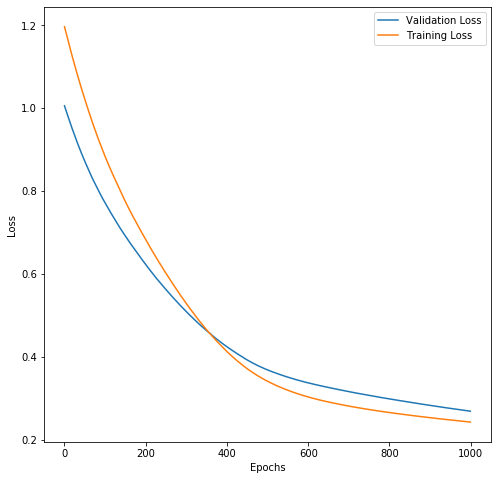

In [13]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Using the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

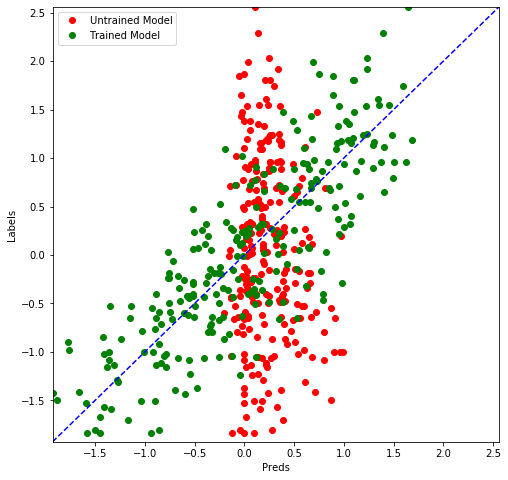

In [16]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

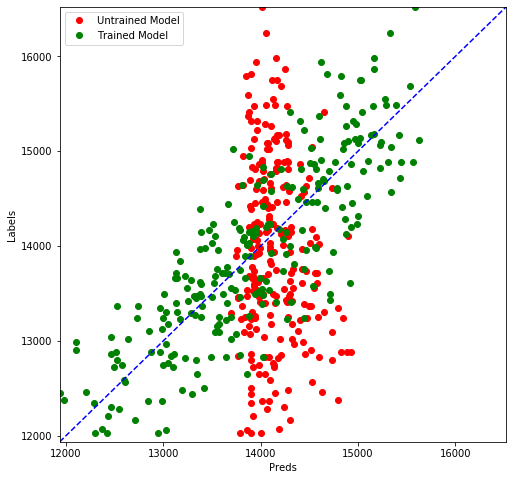

In [15]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)